In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = 'data/stage1/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
patients = patients[:10]

# Loading scans

In [3]:
path = '/home/katya/data/stage1/'

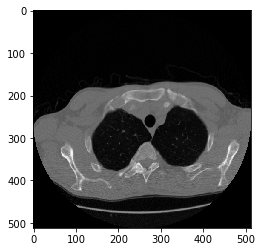

In [38]:
lung = dicom.read_file('/home/katya/data/stage1/0015ceb851d7251b8f399e39779d1e7d/00ac2629fe659e68f4879da4812af659.dcm')

sl = lung.pixel_array
sl[sl == -2000] = 0
plt.imshow(sl, cmap=plt.cm.gray);

In [4]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [5]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image < -1000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [6]:
patientDict = {}
patientPixelsDict = {}

for patient in patients:
    print (patient)
    patientDict[patient] = load_scan(INPUT_FOLDER + patient)
    patientPixelsDict[patient] = get_pixels_hu(patientDict[patient])

0015ceb851d7251b8f399e39779d1e7d
0030a160d58723ff36d73f41b170ec21
003f41c78e6acfa92430a057ac0b306e
006b96310a37b36cccb2ab48d10b49a3
008464bb8521d09a42985dd8add3d0d2
0092c13f9e00a3717fdc940641f00015
00986bebc45e12038ef0ce3e9962b51a
00cba091fa4ad62cc3200a657aeb957e
00edff4f51a893d80dae2d42a7f45ad1
0121c2845f2b7df060945b072b2515d7


# 2. Resampling

### 2.1. Calculating

In [88]:
def resample(image, scan, z=3):
    
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    new_spacing = np.array((z, spacing[1]*2., spacing[2]*2.))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    print (image.shape)
    return image, new_spacing

In [89]:
pixResampledDict = {}
spacingDict = {}

for patient in patients:
    print (patient)
    pixResampledDict[patient], spacingDict[patient] = resample(patientPixelsDict[patient], patientDict[patient], 3)

0015ceb851d7251b8f399e39779d1e7d
(130, 256, 256)
0030a160d58723ff36d73f41b170ec21
(110, 256, 256)
003f41c78e6acfa92430a057ac0b306e
(116, 256, 256)
006b96310a37b36cccb2ab48d10b49a3


/opt/anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(115, 256, 256)
008464bb8521d09a42985dd8add3d0d2
(97, 256, 256)
0092c13f9e00a3717fdc940641f00015
(114, 256, 256)
00986bebc45e12038ef0ce3e9962b51a
(102, 256, 256)
00cba091fa4ad62cc3200a657aeb957e
(112, 256, 256)
00edff4f51a893d80dae2d42a7f45ad1
(112, 256, 256)
0121c2845f2b7df060945b072b2515d7
(115, 256, 256)


### 2.2. Visualizing 

#### 2.2.1. Initial scans

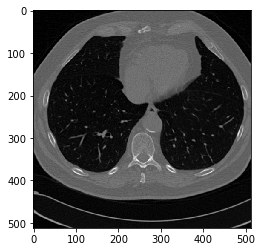

In [86]:
patient = patients[9]

sl = patientPixelsDict[patient][70]
sl[sl == -2000] = 0
plt.imshow(sl, cmap=plt.cm.gray);

#### 2.2.2. Resampled [3,3,3]

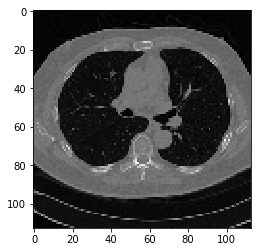

In [87]:
sl = pixResampledDict[patient][70]
sl[sl == -2000] = 0
plt.imshow(sl, cmap=plt.cm.gray);

#### 2.2.3. Resampled, [3, original, original]

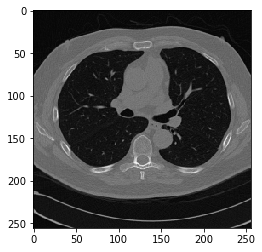

In [83]:
sl = pixResampledDict[patient][70]
sl[sl == -2000] = 0
plt.imshow(sl, cmap=plt.cm.gray);

# 3. Resizing

## 3.1. Calculating

In [161]:
def resize(patients):
    
    pixResizeDict = {}
    
    zMax = max([z.shape[0] for z in pixResampledDict.values()])
    for patient in patients:
        z,x,y = pixResampledDict[patient].shape
        if z < zMax:
            extraSlices = np.ones((zMax-z,x,y))*(-1000)
            pixResizeDict[patient] = np.concatenate((pixResampledDict[patient], extraSlices))
            
        else:
            print (patient)
            pixResizeDict[patient] = pixResampledDict[patient]
            
    return pixResizeDict, zMax

In [130]:
pixResizeDict, zMax = resize(patients)

0015ceb851d7251b8f399e39779d1e7d


In [180]:
for patient in patients:
    np.save('/home/katya/processed_data/'+patient, pixResizeDict[patient])

## 3.2. Visualizing the result

#### 3.2.1. 2D

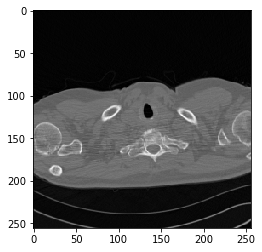

In [154]:
sl = pixResizeDict[patients[5]][113]
sl[sl == -2000] = 0
plt.imshow(sl, cmap=plt.cm.gray);

#### 3.2.2. 3D

In [155]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.30)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

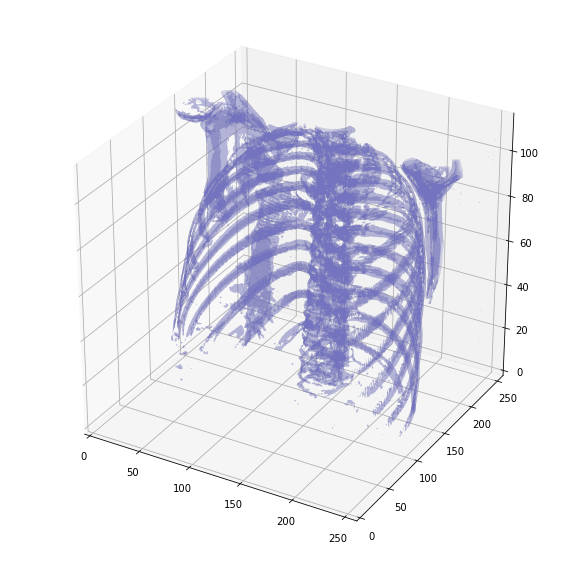

In [159]:
plot_3d(pixResampledDict[patients[5]], 400)

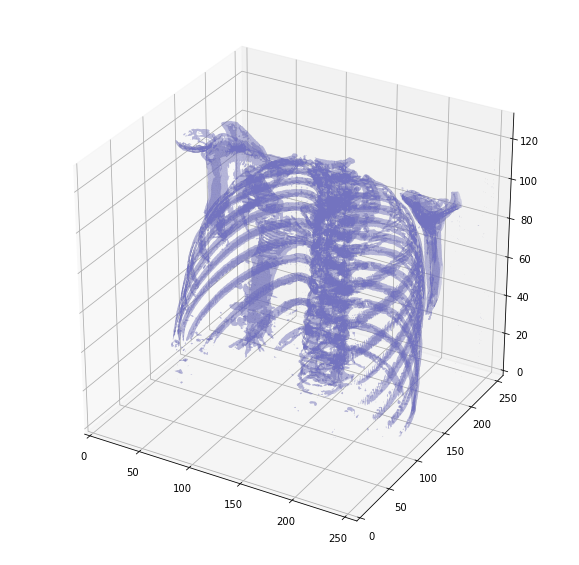

In [160]:
plot_3d(pixResizeDict[patients[5]], 400)